#Analisis Sentimen Aplikasi Brimo di Play Store

Pada proyek ini saya melakukan analissi sentimen pada aplikasi brimo dengan komentar di play store. Tujuannya adalah untuk mengetahui persepsi pengguna terhadap aplikasi, baik dari sisi positif, negatif, maupun netral.

##Import Library

In [3]:
!pip install tensorflow

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import joblib
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Loading dataset hasil scrapping

In [112]:
df = pd.read_csv('brimo_dataset.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,24868505-ec59-4b9f-9814-652642d8cc5b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Hasil Update hanya mengutamakan tampilan saja ...,1,7,2.1.0,2021-01-13 22:05:02,"Hai, Sobat BRI. Mohon maaf atas kendala yang d...",2025-01-12 11:10:06,2.1.0
1,1310ede7-796f-40f8-8965-a5cfd49ab556,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,setelah update terakhir selalu muncul notifika...,2,29,2.81.0,2025-04-02 01:32:21,"Hai Sobat BRI, mohon maaf atas ketidaknyamanan...",2025-04-02 02:31:59,2.81.0
2,27d47c37-0771-4467-bec6-ebf8e281b01d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolong donk brimo. kalo mau tranfer sesama bri...,3,3,2.81.0,2025-04-12 13:48:06,"Hai Sobat BRI, mohon maaf atas kendala yang di...",2025-04-12 14:17:46,2.81.0
3,39c2205a-65d9-4871-b08f-e72eea8fa526,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,buka aplikasi Brimo tiba2 mental keluar sendir...,4,44,2.81.0,2025-03-25 02:58:54,"Hai Sobat BRI, mohon maaf atas ketidaknyamanan...",2025-03-25 03:28:17,2.81.0
4,6af367cf-4fce-4f7d-a818-90140d3337ce,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,awalnya ngebug gitu tiap mau tf ke ewallet pas...,1,6,2.80.0,2025-04-10 01:53:53,"Hai Sobat BRI, mohon maaf atas kendala login B...",2025-04-10 02:13:24,2.80.0


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  9341 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          9940 non-null   object
 9   repliedAt             9940 non-null   object
 10  appVersion            9341 non-null   object
dtypes: int64(2), object(9)
memory usage: 859.5+ KB


Dataset ini berisi 10.000 entri dan 11 kolom, dengan sebagian besar data terisi lengkap. Namun, kolom reviewCreatedVersion dan appVersion memiliki sekitar 659 data yang hilang, sementara replyContent dan repliedAt tidak terisi penuh, menunjukkan sebagian ulasan belum dibalas developer. Dataset ini terdiri dari dua kolom numerik (score dan thumbsUpCount), sisanya bertipe object. Untuk analisis sentimen, saya fokus pada kolom content (komentar pengguna) dan score (rating aplikasi Brimo).

In [115]:
df = df[['content', 'score']]
df.head(10)

,content,score
0,Hasil Update hanya mengutamakan tampilan saja ...,1
1,setelah update terakhir selalu muncul notifika...,2
2,tolong donk brimo. kalo mau tranfer sesama bri...,3
3,buka aplikasi Brimo tiba2 mental keluar sendir...,4
4,awalnya ngebug gitu tiap mau tf ke ewallet pas...,1
5,aplikasi sy stelah update malah crash force cl...,2
6,Aplikasinya makin jelek aja !!! Kenapa harus m...,1
7,Setelah di update sekarang jadi ngga bisa tran...,2
8,"agak unik sih , udah aplikasinya sering update...",2
9,"Habis update terbaru malah sering force close,...",1


In [116]:
df.isnull().sum()

,0
content,0
score,0


Tidak terdapat missing value pada kolom content dan score

In [117]:
df.duplicated().sum()

np.int64(5)

tidak terdapat juga data yang duplikat

##Preprosessing data

- **Case Folding**
Mengkonversi semua  huruf menjadi huruf kecil

In [118]:
df['content'] = df['content'].astype(str).str.lower()

- **Menghapus Emoji**
Fungsi ini membantu membersihkan teks dari emoji karena emoji bisa menjadi noise (gangguan) jika tidak dianalisis secara khusus.

In [119]:
def removeEmoji(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['content'] = df['content'].apply(removeEmoji)

- Membersihkan teks dari mention, hashtag.

In [120]:
def removeMisc(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)   # hapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)   # hapus hashtag
    text = re.sub(r'http\S+', '', text)          # hapus URL
    return text

df['content'] = df['content'].apply(removeMisc)

- Menghapus tanda baca, angka, serta spasi berlebih.

In [121]:
#Remove Punctuation
df['content'] = df['content'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Numbers
df['content'] = df['content'].str.replace(r'\d+', '', regex=True)

#Remove Extra Spaces
df['content'] = df['content'].str.replace(r'\s+', ' ', regex=True).str.strip()

- menghapus kata-kata umum (stopwords) dalam Bahasa Indonesia yang tidak memiliki makna penting dalam analisis, seperti “dan”, atau “adalah”. Dengan menggabungkan stopwords dari NLTK dan Sastrawi.

In [122]:
stopword_nltk = set(stopwords.words('indonesian'))
stopword_sastrawi = set(StopWordRemoverFactory().get_stop_words())
all_stopwords = stopword_nltk.union(stopword_sastrawi)

def removeStopwords(text):
    tokens = text.split()
    filtered = [word for word in tokens if word not in all_stopwords]
    return ' '.join(filtered)

df['content'] = df['content'].apply(removeStopwords)

- Melakukan stemming, yaitu mengubah setiap kata ke bentuk dasarnya. Dengan menggunakan stemmer dari Sastrawi

In [123]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)


df['content'] = df['content'].apply(stemmingText)

- Menghapus stopword secara manual

In [124]:
stopwords_manual = list(set([
    'yg', 'udah', 'dan', 'di', 'ke', 'dari', 'itu', 'untuk', 'dengan', 'karena', 'jadi', 'atau', 'pada',
    'jika', 'agar', 'oleh', 'seperti', 'saja', 'kami', 'kita', 'anda', 'sudah', 'belum', 'masih',
    'hanya', 'juga', 'sekarang', 'akan', 'bisa', 'dapat', 'harus','bgt', 'mau', 'semua', 'bagi',
    'setelah', 'sebelum', 'mereka', 'aku', 'saya', 'kamu', 'apa', 'kenapa', 'bagaimana', 'ya',
    'oh', 'eh', 'nih', 'toh', 'aja', 'gak', 'x', 'g', '@', 'ga', 'gk', 'tp', 'tdk', 'sih', 'pas',
    'nya', 'dong', 'lah', 'lho', 'deh', 'kok', 'kan', 'pun', 'jadiin', 'bakal',
    'tetep', 'malah', 'lagi', 'nah', 'punya', 'padahal', 'banget',
    'buat', 'semoga', 'kalau', 'kalo', 'sampe', 'kayak', 'biar', 'cuma', 'maksud', 'tapi',
    'coba','apk', 'mohon','utk', 'bs', 'pdhl', 'aplikasi', 'sy', 'sya', 'saye', 'sayah', 'gue', 'gw', 'gua',
    'loe', 'lu', 'dia', 'ngga','uda', 'nggak', 'ni', 'dgn', 'dg', 'pula', 'nyaa', 'memang', 'sedang', 'udahh', 'udahhh',
    'katanya', 'hmm', 'oke', 'iya', 'iyaaa', 'ok', 'amat', 'sekali', 'doang', 'loh', 'terus',
    'baru', 'lama', 'sbnrnya', 'bener', 'beneran', 'parah', 'bikin', 'mirip', 'semacam', 'begitu',
    'gitu', 'gini', 'begini', 'dst', 'dll', 'dsb', 'okay',
    'cmn', 'jd', 'jg', 'dr', 'krn', 'lg', 'gin', 'syg', 'sm', 'n', 'dmn', 'trs', 'jdi','sdh', 'uda', 'dg', 'dr',
    'ttp', 'eh', 'd', 'tpi', 'ampun', 'tibatiba', 'it', 'klo',
    'rb', 'yaa', 'tuh', 'atas', 'dikit', 'masak', 'sedia',
    'ikut', 'kasi', 'lumayan', 'pasang', 'brimo', 'trus'
]))


def remove_stopwords(text):
    if pd.isnull(text):
        return ""
    words = text.split()
    words = [word for word in words if word not in stopwords_manual]
    return ' '.join(words)

df['content'] = df['content'].apply(remove_stopwords)


In [125]:
df.head()

,content,score
0,hasil update utama tampil fungsi sajasekarang ...,1
1,update muncul notifikasi jaring buruk jaring s...,2
2,donk tranfer bri pake tanda nama alias salah t...,3
3,buka mental sendiriharus hapus cache data dulu...,4
4,ngebug tf ewallet tulis akun hapus install ula...,1


##labeling


Menggunakan VADER untuk menganalisis sentimen teks dalam kolom content, memberi label 'positif', 'negatif', atau 'netral' berdasarkan skor sentimen, dan menyimpannya dalam kolom vader_sentiment.

In [126]:
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk memberi label dari skor VADER
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positif'
    elif score <= -0.05:
        return 'negatif'
    else:
        return 'netral'

df['vader_sentiment'] = df['content'].apply(get_vader_sentiment)

Distribusi tiap kategori

In [127]:
print(df['vader_sentiment'].value_counts())

vader_sentiment
netral     8371
negatif    1013
positif     616
Name: count, dtype: int64


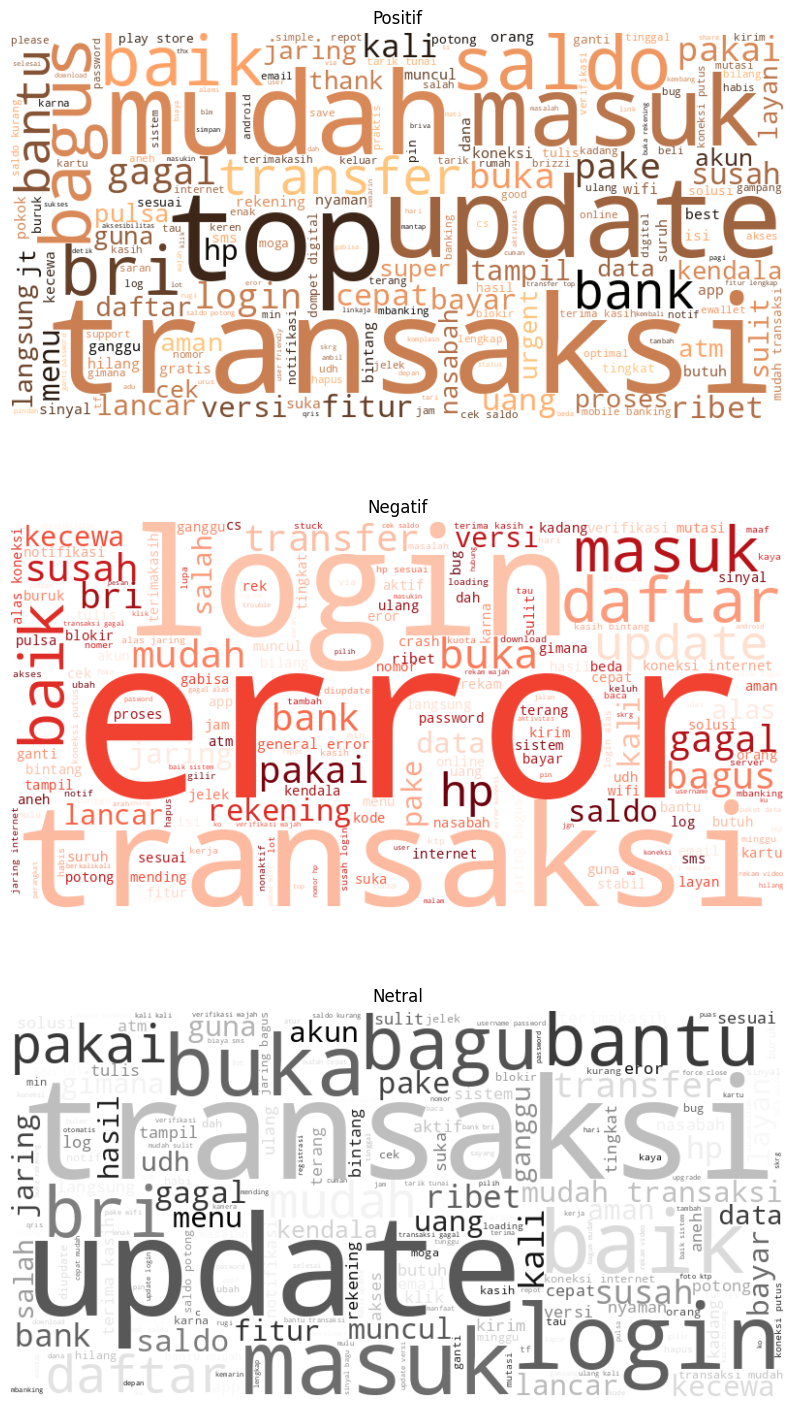

In [129]:
# Menggabungkan teks berdasarkan sentimen
positive_text = ' '.join(df[df['vader_sentiment'] == 'positif']['content'].dropna())
negative_text = ' '.join(df[df['vader_sentiment'] == 'negatif']['content'].dropna())
neutral_text = ' '.join(df[df['vader_sentiment'] == 'netral']['content'].dropna())

# Membuat word cloud
positive_wordcloud = WordCloud(
    background_color='white',
    colormap='copper',
    width=800,
    height=400
).generate(positive_text)

negative_wordcloud = WordCloud(
    background_color='white',
    colormap='Reds',
    width=800,
    height=400
).generate(negative_text)

neutral_wordcloud = WordCloud(
    background_color='white',
    colormap='Greys',
    width=800,
    height=400
).generate(neutral_text)

fig, axes = plt.subplots(3, 1, figsize=(10, 18))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positif')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negatif')

axes[2].imshow(neutral_wordcloud, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title('Netral')
plt.show()

### **Positif**
**Kata Utama:** *transaksi, update, mudah, bantu, bagus, cepat, top, baik*  
**Penjelasan:**  
Pengguna memberikan ulasan positif karena aplikasi BRImo dinilai memudahkan berbagai aktivitas perbankan, seperti transfer dan cek saldo. Kata "mudah" dan "cepat" menandakan pengalaman pengguna yang lancar dan efisien. Kata "bantu" menunjukkan bahwa fitur-fitur aplikasi dianggap membantu menyelesaikan kebutuhan perbankan sehari-hari. "Update" juga muncul dalam konteks positif, yang bisa berarti pembaruan aplikasi membawa perbaikan atau fitur baru yang disukai pengguna.

---

### **Negatif**  
**Kata Utama:** *error, login, gagal, susah, update, kecewa, daftar*  
**Penjelasan:**  
Keluhan terbanyak datang dari masalah teknis, terutama terkait login yang sering gagal atau error setelah pembaruan aplikasi. Kata "susah" menunjukkan kesulitan yang dialami pengguna saat mengakses aplikasi atau menggunakan fitur tertentu. Kata "daftar" juga muncul, mengindikasikan bahwa proses registrasi dianggap tidak mudah oleh sebagian pengguna. "Update" dalam konteks ini bersifat negatif pengguna merasa update justru membuat aplikasi bermasalah.

---

### **Netral**  
**Kata Utama:** *transaksi, update, login, daftar, pakai, fitur, masuk*  
**Penjelasan:**  
Kata-kata netral biasanya muncul dalam komentar yang bersifat informatif tanpa emosi kuat. Contohnya seperti "sudah update versi terbaru", "login pakai sidik jari", atau "fitur transfer tersedia". Komentar seperti ini tidak menunjukkan kepuasan atau kekecewaan, tapi memberikan informasi tentang penggunaan aplikasi secara umum.

#Modeling

- Feature Extraction Menggunakan TF-IDF

In [130]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['content'])
y = df['vader_sentiment']

# Skema 1: SVM - Ekstraksi Fitur: TF-IDF, Pembagian Data: 70/30



In [131]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_svm, y_train_svm)

y_pred_svm = svm_model.predict(X_test_svm)
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)

print("Hasil Skema 1:")
print(f"Akurasi SVM: {accuracy_svm * 100:.2f}%")
print(classification_report(y_test_svm, y_pred_svm, target_names=['negatif', 'netral', 'positif']))


Hasil Skema 1:
Akurasi SVM: 95.57%
              precision    recall  f1-score   support

     negatif       0.98      0.85      0.91       330
      netral       0.95      1.00      0.98      2483
     positif       0.98      0.56      0.71       187

    accuracy                           0.96      3000
   macro avg       0.97      0.80      0.87      3000
weighted avg       0.96      0.96      0.95      3000



Pada Skema 1, model SVM mencapai akurasi tinggi sebesar 95.57%. Model sangat baik mengenali komentar netral (recall 1.00, f1-score 0.91), cukup baik untuk negatif (recall 0.85), namun kurang optimal untuk positif (recall hanya 0.56), yang berarti cukup banyak komentar positif salah klasifikasi. Secara keseluruhan, model bekerja sangat baik terutama karena didukung jumlah data netral yang dominan.

# Skema 2: Random Forest - Ekstraksi Fitur: TF-IDF, Pembagian Data: 80/20

In [132]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_rf, y_train_rf)

y_pred_rf = rf_model.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)

print("\nHasil Skema 2:")
print(f"Akurasi Random Forest: {accuracy_rf * 100:.2f}%")
print(classification_report(y_test_rf, y_pred_rf, target_names=['negatif', 'netral', 'positif']))


Hasil Skema 2:
Akurasi Random Forest: 96.75%
              precision    recall  f1-score   support

     negatif       0.98      0.88      0.93       202
      netral       0.96      1.00      0.98      1679
     positif       1.00      0.67      0.80       119

    accuracy                           0.97      2000
   macro avg       0.98      0.85      0.90      2000
weighted avg       0.97      0.97      0.97      2000



Pada Skema 2, model Random Forest menghasilkan akurasi sebesar 96.75%, menunjukkan performa yang sangat baik. Model sangat akurat dalam mengklasifikasikan komentar netral (recall 1.00, f1-score 0.98), cukup baik untuk komentar negatif (recall 0.88, f1-score 0.93), dan cukup memadai untuk komentar positif (recall 0.67, f1-score 0.80). Meskipun recall untuk kelas positif masih rendah, hasil ini lebih baik dibandingkan Skema 1. Secara umum, model menunjukkan performa stabil di semua kelas, dengan macro average f1-score sebesar 0.90 dan weighted average f1-score sebesar 0.97, menandakan kemampuan klasifikasi yang baik.

# Skema 3: LSTM - Ekstraksi Fitur: TF-IDF, Pembagian Data: 80/20

In [133]:
X_pad = pad_sequences(X_tfidf.toarray(), padding='post', maxlen=500)

# One-hot encoding untuk label
y_lstm = to_categorical(y.map({'negatif': 0, 'netral': 1, 'positif': 2}))

# Split data latih dan uji (80:20)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_pad, y_lstm, test_size=0.2, random_state=42
)

# LSTM Model
model = Sequential()
model.add(Embedding(input_dim=X_pad.shape[1], output_dim=100, input_length=500))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)

# Evaluasi
train_loss, train_acc = model.evaluate(X_train_lstm, y_train_lstm, verbose=0)
test_loss, test_acc = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)

print(f"Akurasi LSTM (train): {train_acc:.4f}")
print(f"Akurasi LSTM (test) : {test_acc:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 506ms/step - accuracy: 0.8212 - loss: 0.5898 - val_accuracy: 0.8395 - val_loss: 0.5496
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 151s 545ms/step - accuracy: 0.8383 - loss: 0.5549 - val_accuracy: 0.8395 - val_loss: 0.5512
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 531ms/step - accuracy: 0.8305 - loss: 0.5707 - val_accuracy: 0.8395 - val_loss: 0.5481
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 504ms/step - accuracy: 0.8296 - loss: 0.5733 - val_accuracy: 0.8395 - val_loss: 0.5521
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 499ms/step - accuracy: 0.8338 - loss: 0.5628 - val_accuracy: 0.8395 - val_loss: 0.5464
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 485ms/step - accuracy: 0.8318 - loss: 0.5666 - val_accuracy: 0.8395 - val_loss: 0.5468
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 147s 502ms/step - accuracy: 0.8343 - loss: 0.5608 - val_accuracy: 0.8395 - val_loss: 0.5465
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 501ms/step - accuracy: 0.8372 - loss: 0.55

In [134]:
hasil_akurasi = {
    'Model': ['SVM', 'Random Forest', 'LSTM'],
    'Akurasi': [
        accuracy_svm * 100,
        accuracy_rf * 100,
        test_acc * 100
    ]
}

df_akurasi = pd.DataFrame(hasil_akurasi)
print(df_akurasi)

           Model    Akurasi
0            SVM  95.566667
1  Random Forest  96.750000
2           LSTM  83.950001


##Save model

saya mengambil model randomforest untuk di tes dengan data baru karena memiliki nilai accuracy lebih tinggi di antara lainnya.


In [135]:
# Simpan model dan TF-IDF vectorizer
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [136]:
# Load model dan TF-IDF vectorizer
rf_model = joblib.load('random_forest_model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')

##Inference

In [137]:
new_data = ["Aplikasinya super cepat dan mudah diakses", "Kecewa sering error dan gagal login", "Biasa aja, tidak terlalu istimewa"]

X_new_tfidf = tfidf.transform(new_data)
predictions = rf_model.predict(X_new_tfidf)

print(predictions)

['positif' 'negatif' 'netral']
